# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
- The data can either be stored in a raster file that can be conveniently loaded into gempy.
- For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [1]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. The common procedure to set up a model:

In [2]:
geo_model = gp.create_model('Single_layer_topo')

gp.init_data(geo_model, extent=[440720, 441129, 69280,69689,-200,250],resolution = (50,50,50),
                         path_i = os.pardir+"/input_data/onelayer_interfaces.csv",
                         path_o = os.pardir+"/input_data/onelayer_orient.csv")



Single_layer_topo  2019-04-29 10:57

In [3]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,vertices,edges,id
0,layer1,Default series,1,False,#ff8000,nan,nan,1
1,basement,Basement,1,True,#88cc60,nan,nan,2


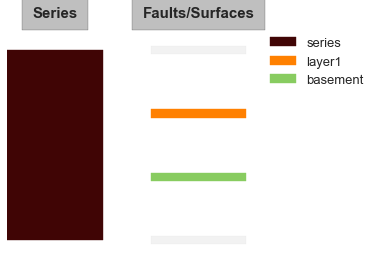

In [4]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

### 2. Adding topography

#### 2 a. Load from raster file

In [5]:
fp = os.pardir+"/input_data/bogota.tif"

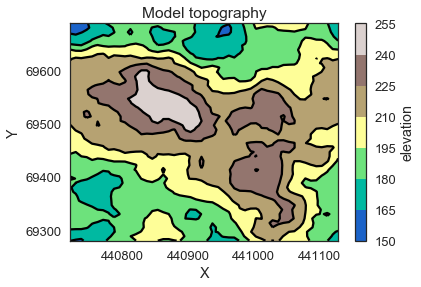

In [6]:
geo_model.grid.set_topography()

In [7]:
geo_model.grid.topography.load_from_gdal(filepath=fp)

[440720 471440  69280 100000] [512 512]
Cropped raster to geo_model.grid.extent.
[440720 441129  69280  69689] [7 7]
storing converted file...


[440720 471440  69280 100000] [512 512]
Cropped raster to geo_model.grid.extent.
[440720 441129  69280  69689] [7 7]
storing converted file...


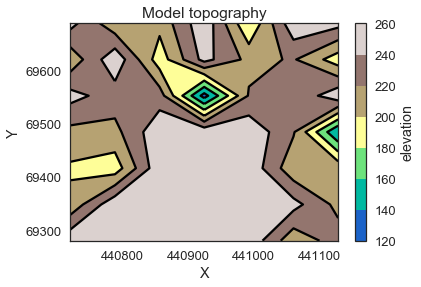

In [8]:
geo_model.set_topography(source='gdal',filepath=fp)

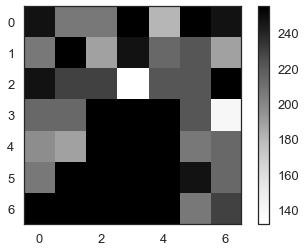

In [9]:
plt.imshow(geo_model.grid.topography.topo.dem_zval)
plt.colorbar()

#### 2.b create fun topography

showing...


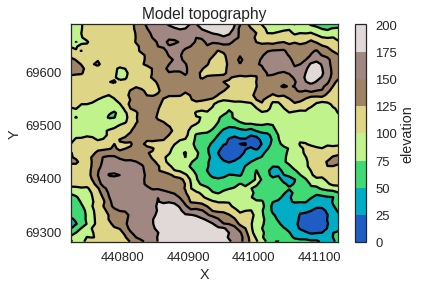

In [6]:
geo_model.add_topography(d_z=np.array([0,200]))

Gefahr weil resolution


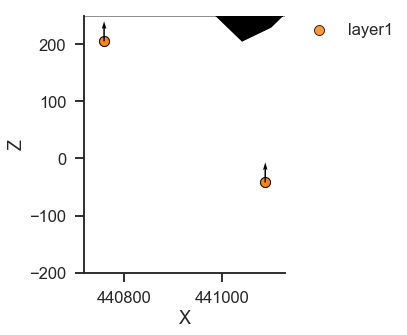

In [10]:
gp.plot.plot_data(geo_model)

In [11]:
gp.set_interpolation_data(geo_model,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [13]:
sol2 = gp.compute_model_at(geo_model.grid.topography.values, geo_model, compute_mesh=False)

In [ ]:
geo_model.solutions.

In [14]:
from gempy.plot.visualization_2d import PlotData2D

In [15]:
plot=PlotData2D(geo_model)

In [16]:
plot.plot_map(sol2)

ValueError: cannot reshape array of size 125000 into shape (7,7)

In [12]:
geo_model.grid.resolution

array([ 0, -1,  1])

In [13]:
geo_model.surfaces.modify_order_surfaces(1,0)

In [20]:
sol = gp.compute_model(geo_model, compute_mesh=False)

In [21]:
sol.lith_block.shape

(125000,)

In [22]:
geo_model.series

,order_series,BottomRelation
series,1,Erosion


In [23]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


In [24]:
import copy

In [25]:
old_grid = copy.copy(geo_model.grid)

In [26]:
old_grid.values.shape

(2500, 3)

In [27]:
sol = gp.compute_model_at(old_grid.values, geo_model, compute_mesh=False)

In [28]:
geo_model.interpolator.set_initial_results_matrices()

In [29]:
sol.grid.values.shape

(2500, 3)

In [30]:
geo_model.solutions.grid.resolution

array([0.e+000, 5.e-324, 5.e-324])

In [31]:
sol2.lith_block.shape

(2500,)

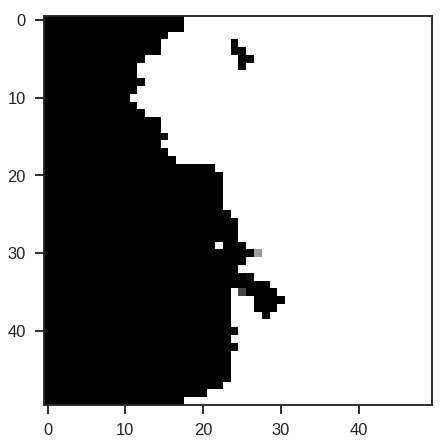

In [32]:
plt.imshow(sol2.lith_block.reshape(50,50),origin='upper')

In [28]:
sol2.grid.values.shape

(2500, 3)

Gefahr weil resolution
Gefahr weil resolution


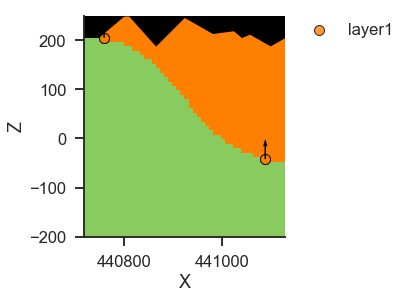

In [19]:
%matplotlib inline
gp.plot.plot_section(geo_model, cell_number=42, block=geo_model.solutions.lith_block,
                         direction='y', plot_data=True,show_faults=False)

In [ ]:
geo_model.topography._line_in_section()